In [16]:
import numpy as np
from sklearn.metrics import *
from imbens.metrics import *


pred = np.load('ecoli1_result/ecoli1_UncertaintyAwareDeepForest_pred.npy')
true = np.load('ecoli1_result/ecoli1_UncertaintyAwareDeepForest_true_label.npy')
proba = np.load('ecoli1_result/ecoli1_UncertaintyAwareDeepForest_proba.npy')

gmean = geometric_mean_score(true, pred)
f1 = f1_score(true, pred, average='macro')
acc = accuracy_score(true, pred)
roc_auc = roc_auc_score(true, proba[:,1])
pr_auc = average_precision_score(true, proba[:,1])

print('Gmean:', gmean)
print('F1:', f1)
print('Accuracy:', acc)
print('ROC-AUC:', roc_auc)
print('PR-AUC:', pr_auc)


Gmean: 0.8429453518880732
F1: 0.8406946368309983
Accuracy: 0.8482142857142857
ROC-AUC: 0.9186608246264464
PR-AUC: 0.8841494251417841


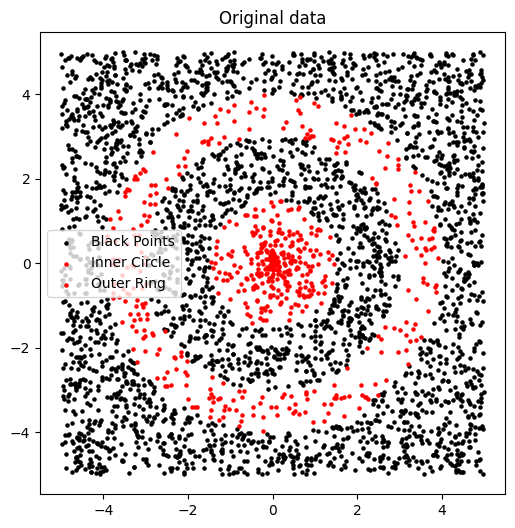

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 中间的实心圆（红色点）
n_inner_points = 300
inner_radius = 1.5
theta_inner = np.random.uniform(0, 2 * np.pi, n_inner_points)
radii_inner = np.random.uniform(0, inner_radius, n_inner_points)
red_inner_x = radii_inner * np.cos(theta_inner)
red_inner_y = radii_inner * np.sin(theta_inner)

# 外面的环（红色点）
n_outer_points = 300
outer_radius_min, outer_radius_max = 3, 4
theta_outer = np.random.uniform(0, 2 * np.pi, n_outer_points)
radii_outer = np.random.uniform(outer_radius_min, outer_radius_max, n_outer_points)
red_outer_x = radii_outer * np.cos(theta_outer)
red_outer_y = radii_outer * np.sin(theta_outer)

# 黑色点（排除红色区域）
n_black_points = 3000
black_x, black_y = [], []
while len(black_x) < n_black_points:
    x = np.random.uniform(-5, 5)
    y = np.random.uniform(-5, 5)
    distance = np.sqrt(x**2 + y**2)
    # 排除红色区域（实心圆和环）
    if not (distance <= inner_radius or (outer_radius_min <= distance <= outer_radius_max)):
        black_x.append(x)
        black_y.append(y)

# 绘图
plt.figure(figsize=(6, 6))
plt.scatter(black_x, black_y, c='black', s=5, label="Black Points")
plt.scatter(red_inner_x, red_inner_y, c='red', s=5, label="Inner Circle")
plt.scatter(red_outer_x, red_outer_y, c='red', s=5, label="Outer Ring")
plt.title("Original data")
plt.axis("equal")
plt.legend()
plt.show()


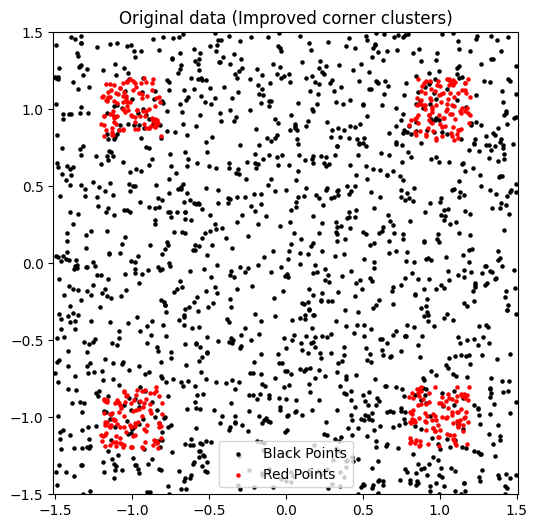

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
n_red_points = 400  # 红色点总数
n_black_points = 1500  # 黑色点总数
plot_range = [-1.5, 1.5]  # 绘图范围

# 红色点生成（分布在四个角落的更大区域）
red_x = []
red_y = []
corner_regions = [(-1.2, -0.8, 0.8, 1.2), (0.8, 1.2, 0.8, 1.2),  # 左上和右上
                  (-1.2, -0.8, -1.2, -0.8), (0.8, 1.2, -1.2, -0.8)]  # 左下和右下

for region in corner_regions:
    x_min, x_max, y_min, y_max = region
    x = np.random.uniform(x_min, x_max, n_red_points // 4)
    y = np.random.uniform(y_min, y_max, n_red_points // 4)
    red_x.extend(x)
    red_y.extend(y)

# 黑色点生成（均匀分布，但允许部分进入红色区域）
black_x = np.random.uniform(plot_range[0], plot_range[1], n_black_points)
black_y = np.random.uniform(plot_range[0], plot_range[1], n_black_points)

# 绘图
plt.figure(figsize=(6, 6))
plt.scatter(black_x, black_y, c='black', s=5, label="Black Points")
plt.scatter(red_x, red_y, c='red', s=5, label="Red Points")
plt.title("Original data (Improved corner clusters)")
plt.axis("equal")
plt.xlim(plot_range)
plt.ylim(plot_range)
plt.legend()
plt.show()


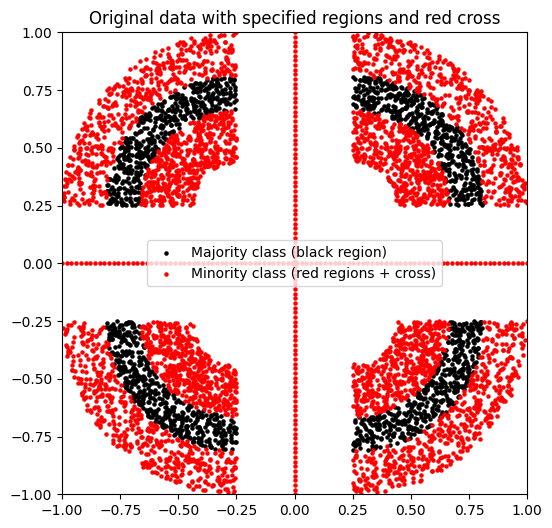

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子
np.random.seed()

# 定义所属区域的红色和黑色
def define_regions(center_x, center_y, radius, angle_start, angle_end):
    """
    定义红色和黑色区域的边界，包括十字线
    """
    regions = {
        "red_inner": {
            "radius_min": 0.25 * radius,
            "radius_max": 0.55 * radius,
            "angle_start": angle_start,
            "angle_end": angle_end,
            "center": (center_x, center_y),
        },
        "black": {
            "radius_min": 0.55 * radius,
            "radius_max": 0.75 * radius,
            "angle_start": angle_start,
            "angle_end": angle_end,
            "center": (center_x, center_y),
        },
        "red_outer": {
            "radius_min": 0.75 * radius,
            "radius_max": 1.0 * radius,
            "angle_start": angle_start,
            "angle_end": angle_end,
            "center": (center_x, center_y),
        },
        "red_cross": {
            "radius_min": 0.0,  # 专门划分十字线区域
            "radius_max": 1.0,
            "angle_start": 0,
            "angle_end": 2 * np.pi,
            "center": (0, 0),  # 十字线以中心为准
            "is_cross": True,  # 标记为十字线区域
        }
    }
    return regions

# 在指定区域生成均匀分布的样本
def generate_samples(region, num_points):
    """
    在给定区域生成均匀分布的样本
    """
    center_x, center_y = region["center"]
    radius_min = region["radius_min"]
    radius_max = region["radius_max"]
    angle_start = region["angle_start"]
    angle_end = region["angle_end"]

    if region.get("is_cross", False):
        # 生成十字线区域的样本
        cross_x_horizontal = np.linspace(-1, 1, num_points // 2)
        cross_y_horizontal = np.zeros(num_points // 2)  # 水平线

        cross_y_vertical = np.linspace(-1, 1, num_points // 2)
        cross_x_vertical = np.zeros(num_points // 2)  # 垂直线

        # 合并水平和垂直十字线
        x = np.concatenate([cross_x_horizontal, cross_x_vertical])
        y = np.concatenate([cross_y_horizontal, cross_y_vertical])
    else:
        # 均匀采样角度和半径
        angles = np.random.uniform(angle_start, angle_end, num_points)
        radii = np.sqrt(np.random.uniform(radius_min**2, radius_max**2, num_points))

        # 转换为 x, y 坐标
        x = center_x + radii * np.cos(angles)
        y = center_y + radii * np.sin(angles)

    return x, y

# 定义扇形区域
regions_list = []
regions_list.append(define_regions(-0.25, -0.25, 0.75, np.pi, 1.5 * np.pi))
regions_list.append(define_regions(0.25, -0.25, 0.75, 1.5 * np.pi, 2 * np.pi))
regions_list.append(define_regions(-0.25, 0.25, 0.75, 0.5 * np.pi, np.pi))
regions_list.append(define_regions(0.25, 0.25, 0.75, 0, 0.5 * np.pi))

# 初始化红色和黑色样本点集合
minority_class_x_red, minority_class_y_red = [], []
majority_class_x, majority_class_y = [], []

# 在红色和黑色区域生成均匀分布的样本
num_points_per_region = 500
for regions in regions_list:
    # 红色内圈样本
    x_red_inner, y_red_inner = generate_samples(regions["red_inner"], num_points_per_region)
    minority_class_x_red.append(x_red_inner)
    minority_class_y_red.append(y_red_inner)

    # 黑色样本
    x_black, y_black = generate_samples(regions["black"], num_points_per_region)
    majority_class_x.append(x_black)
    majority_class_y.append(y_black)

    # 红色外圈样本
    x_red_outer, y_red_outer = generate_samples(regions["red_outer"], num_points_per_region)
    minority_class_x_red.append(x_red_outer)
    minority_class_y_red.append(y_red_outer)

# 在十字线区域生成样本
x_cross, y_cross = generate_samples(regions_list[0]["red_cross"], 200)
minority_class_x_red.append(x_cross)
minority_class_y_red.append(y_cross)

# 合并所有点
minority_class_x_red = np.concatenate(minority_class_x_red)
minority_class_y_red = np.concatenate(minority_class_y_red)
majority_class_x = np.concatenate(majority_class_x)
majority_class_y = np.concatenate(majority_class_y)

# 绘制图像
plt.figure(figsize=(6, 6))
plt.scatter(majority_class_x, majority_class_y, color='black', s=5, label='Majority class (black region)')
plt.scatter(minority_class_x_red, minority_class_y_red, color='red', s=5, label='Minority class (red regions + cross)')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Original data with specified regions and red cross")
plt.legend()
plt.grid(False)
plt.show()


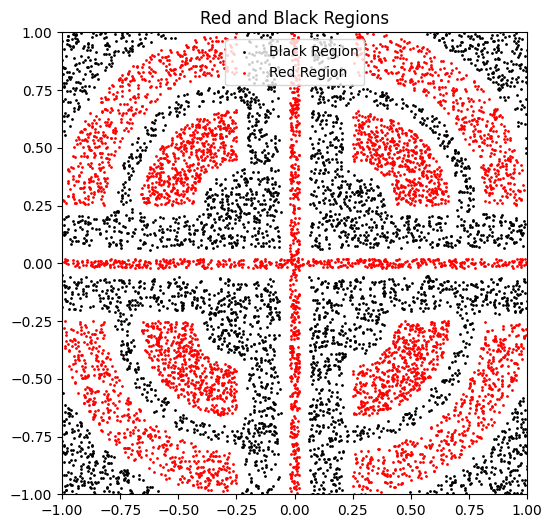

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 在指定区域生成均匀分布的样本
def generate_samples(region, num_points):
    """
    根据区域规则生成样本点
    """
    if region.get("is_cross", False):  # 十字线区域
        # 水平十字线
        horizontal_x = np.random.uniform(-1, 1, num_points // 2)
        horizontal_y = np.random.uniform(-0.02, 0.02, num_points // 2)

        # 垂直十字线
        vertical_x = np.random.uniform(-0.02, 0.02, num_points // 2)
        vertical_y = np.random.uniform(-1, 1, num_points // 2)

        # 合并水平和垂直十字线
        x = np.concatenate([horizontal_x, vertical_x])
        y = np.concatenate([horizontal_y, vertical_y])
    else:  # 扇形区域
        center_x, center_y = region["center"]
        radius_min = region["radius_min"]
        radius_max = region["radius_max"]
        angle_start = region["angle_start"]
        angle_end = region["angle_end"]

        # 均匀采样半径和角度
        radii = np.sqrt(np.random.uniform(radius_min**2, radius_max**2, num_points))
        angles = np.random.uniform(angle_start, angle_end, num_points)

        # 转换为 x, y 坐标
        x = center_x + radii * np.cos(angles)
        y = center_y + radii * np.sin(angles)

    return x, y

# 定义区域规则
def define_regions(center_x, center_y, radius, angle_start, angle_end):
    """
    根据提供的规则定义红色和黑色区域
    """
    return {
        "red_inner": {
            "radius_min": 0.25 * radius,
            "radius_max": 0.55 * radius,
            "angle_start": angle_start,
            "angle_end": angle_end,
            "center": (center_x, center_y),
        },
        "red_outer": {
            "radius_min": 0.75 * radius,
            "radius_max": 1.0 * radius,
            "angle_start": angle_start,
            "angle_end": angle_end,
            "center": (center_x, center_y),
        },
        "red_cross": {
            "is_cross": True,  # 标记为十字线区域
        },
    }

# 定义四个扇形区域和十字线
regions_list = []
regions_list.append(define_regions(-0.25, -0.25, 0.75, np.pi, 1.5 * np.pi))
regions_list.append(define_regions(0.25, -0.25, 0.75, 1.5 * np.pi, 2 * np.pi))
regions_list.append(define_regions(-0.25, 0.25, 0.75, 0.5 * np.pi, np.pi))
regions_list.append(define_regions(0.25, 0.25, 0.75, 0, 0.5 * np.pi))

# 初始化样本集合
red_x, red_y = [], []

# 在红色区域生成样本
num_points_per_region = 500
for region in regions_list:
    # 红色内圈
    x, y = generate_samples(region["red_inner"], num_points_per_region)
    red_x.append(x)
    red_y.append(y)

    # 红色外圈
    x, y = generate_samples(region["red_outer"], num_points_per_region)
    red_x.append(x)
    red_y.append(y)

# 在十字线区域生成样本
x, y = generate_samples(regions_list[0]["red_cross"], 1000)
red_x.append(x)
red_y.append(y)

# 合并红色样本点
red_x = np.concatenate(red_x)
red_y = np.concatenate(red_y)

# 在整个范围内生成黑色样本点
num_black_samples = 10000
x_all = np.random.uniform(-1, 1, num_black_samples)
y_all = np.random.uniform(-1, 1, num_black_samples)

# 判断是否在红色区域
def is_in_red_region(x, y):
    for rx, ry in zip(red_x, red_y):
        if np.sqrt((x - rx) ** 2 + (y - ry) ** 2) < 0.05:  # 半径检查
            return True
    return False

black_indices = [not is_in_red_region(x, y) for x, y in zip(x_all, y_all)]
x_black = x_all[black_indices]
y_black = y_all[black_indices]

# 绘制图像
plt.figure(figsize=(6, 6))
plt.scatter(x_black, y_black, color='black', s=1, label='Black Region')
plt.scatter(red_x, red_y, color='red', s=1, label='Red Region')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Red and Black Regions")
plt.legend()
plt.grid(False)
plt.show()


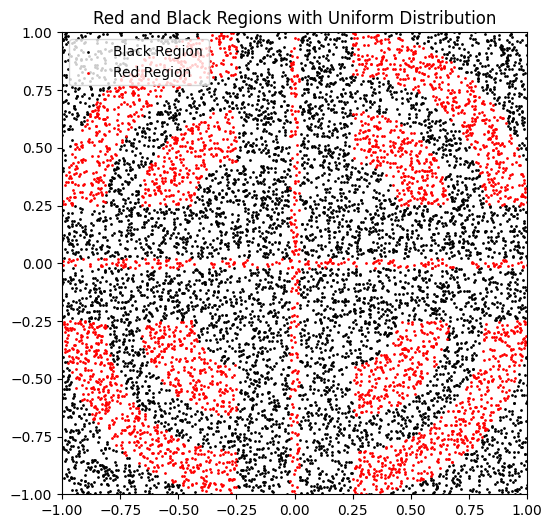

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 判断是否在红色区域
def is_in_red_region(x, y):
    """
    判断点是否在红色区域内，包括：
    1. 红色内圈、外圈（扇形）
    2. 红色十字线区域
    """
    # 定义扇形的逻辑
    def in_sector(cx, cy, r_min, r_max, theta_min, theta_max):
        dx = x - cx
        dy = y - cy
        r = np.sqrt(dx**2 + dy**2)
        theta = np.arctan2(dy, dx)
        theta = np.where(theta >= 0, theta, theta + 2 * np.pi)  # 将角度范围调整到 [0, 2π]
        return (r_min <= r) & (r <= r_max) & (theta_min <= theta) & (theta <= theta_max)

    # 定义四个扇形区域
    sectors = [
        (-0.25, -0.25, 0.25 * 0.75, 0.55 * 0.75, np.pi, 1.5 * np.pi),  # 左下
        (0.25, -0.25, 0.25 * 0.75, 0.55 * 0.75, 1.5 * np.pi, 2 * np.pi),  # 右下
        (-0.25, 0.25, 0.25 * 0.75, 0.55 * 0.75, 0.5 * np.pi, np.pi),  # 左上
        (0.25, 0.25, 0.25 * 0.75, 0.55 * 0.75, 0, 0.5 * np.pi),  # 右上
        (-0.25, -0.25, 0.75 * 0.75, 1.0 * 0.75, np.pi, 1.5 * np.pi),  # 外圈左下
        (0.25, -0.25, 0.75 * 0.75, 1.0 * 0.75, 1.5 * np.pi, 2 * np.pi),  # 外圈右下
        (-0.25, 0.25, 0.75 * 0.75, 1.0 * 0.75, 0.5 * np.pi, np.pi),  # 外圈左上
        (0.25, 0.25, 0.75 * 0.75, 1.0 * 0.75, 0, 0.5 * np.pi),  # 外圈右上
    ]

    # 检查是否在任意扇形区域内
    in_red = np.zeros_like(x, dtype=bool)
    for cx, cy, r_min, r_max, theta_min, theta_max in sectors:
        in_red |= in_sector(cx, cy, r_min, r_max, theta_min, theta_max)

    # 定义十字线区域
    in_horizontal_cross = (-1.0 <= x) & (x <= 1.0) & (-0.02 <= y) & (y <= 0.02)  # 水平
    in_vertical_cross = (-0.02 <= x) & (x <= 0.02) & (-1.0 <= y) & (y <= 1.0)  # 垂直

    # 综合判断
    return in_red | in_horizontal_cross | in_vertical_cross

# 生成整个范围内的点
num_samples = 10000  # 总样本数
x_all = np.random.uniform(-1, 1, num_samples)
y_all = np.random.uniform(-1, 1, num_samples)

# 判断点是否在红色区域
is_red = is_in_red_region(x_all, y_all)

# 分离红色和黑色样本
x_red = x_all[is_red]
y_red = y_all[is_red]
x_black = x_all[~is_red]
y_black = y_all[~is_red]

# 绘制图像
plt.figure(figsize=(6, 6))
plt.scatter(x_black, y_black, color='black', s=1, label='Black Region')
plt.scatter(x_red, y_red, color='red', s=1, label='Red Region')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Red and Black Regions with Uniform Distribution")
plt.legend()
plt.grid(False)
plt.show()


1000
10000


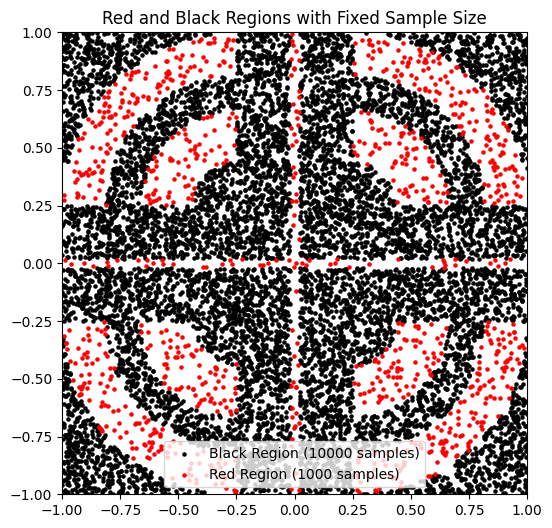

数据已保存到 target_plot1 文件夹下


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 判断是否在红色区域
def is_in_red_region(x, y):
    """
    判断点是否在红色区域内，包括：
    1. 红色内圈、外圈（扇形）
    2. 红色十字线区域
    """
    # 定义扇形的逻辑
    def in_sector(cx, cy, r_min, r_max, theta_min, theta_max):
        dx = x - cx
        dy = y - cy
        r = np.sqrt(dx**2 + dy**2)
        theta = np.arctan2(dy, dx)
        theta = np.where(theta >= 0, theta, theta + 2 * np.pi)  # 将角度范围调整到 [0, 2π]
        return (r_min <= r) & (r <= r_max) & (theta_min <= theta) & (theta <= theta_max)

    # 定义四个扇形区域
    sectors = [
        (-0.25, -0.25, 0.25 * 0.75, 0.55 * 0.75, np.pi, 1.5 * np.pi),  # 左下
        (0.25, -0.25, 0.25 * 0.75, 0.55 * 0.75, 1.5 * np.pi, 2 * np.pi),  # 右下
        (-0.25, 0.25, 0.25 * 0.75, 0.55 * 0.75, 0.5 * np.pi, np.pi),  # 左上
        (0.25, 0.25, 0.25 * 0.75, 0.55 * 0.75, 0, 0.5 * np.pi),  # 右上
        (-0.25, -0.25, 0.75 * 0.75, 1.0 * 0.75, np.pi, 1.5 * np.pi),  # 外圈左下
        (0.25, -0.25, 0.75 * 0.75, 1.0 * 0.75, 1.5 * np.pi, 2 * np.pi),  # 外圈右下
        (-0.25, 0.25, 0.75 * 0.75, 1.0 * 0.75, 0.5 * np.pi, np.pi),  # 外圈左上
        (0.25, 0.25, 0.75 * 0.75, 1.0 * 0.75, 0, 0.5 * np.pi),  # 外圈右上
    ]

    # 检查是否在任意扇形区域内
    in_red = np.zeros_like(x, dtype=bool)
    for cx, cy, r_min, r_max, theta_min, theta_max in sectors:
        in_red |= in_sector(cx, cy, r_min, r_max, theta_min, theta_max)

    # 定义十字线区域
    in_horizontal_cross = (-1.0 <= x) & (x <= 1.0) & (-0.02 <= y) & (y <= 0.02)  # 水平
    in_vertical_cross = (-0.02 <= x) & (x <= 0.02) & (-1.0 <= y) & (y <= 1.0)  # 垂直

    # 综合判断
    return in_red | in_horizontal_cross | in_vertical_cross

# 生成红色区域的点
num_red_samples = 1000
red_x_all = np.random.uniform(-1, 1, num_red_samples * 10)  # 扩大范围生成，筛选后保证1000个点
red_y_all = np.random.uniform(-1, 1, num_red_samples * 10)
is_red = is_in_red_region(red_x_all, red_y_all)

# 筛选红色区域的点
red_x = red_x_all[is_red][:num_red_samples]
red_y = red_y_all[is_red][:num_red_samples]

# 生成黑色区域的点
num_black_samples = 10000
black_x_all = np.random.uniform(-1, 1, num_black_samples * 10)  # 扩大范围生成，筛选后保证10000个点
black_y_all = np.random.uniform(-1, 1, num_black_samples * 10)
is_black = ~is_in_red_region(black_x_all, black_y_all)

# 筛选黑色区域的点
black_x = black_x_all[is_black][:num_black_samples]
black_y = black_y_all[is_black][:num_black_samples]

print(len(red_x))
print(len(black_x))

# 绘制图像
plt.figure(figsize=(6, 6))
plt.scatter(black_x, black_y, color='black', s=5, label='Black Region (10000 samples)')
plt.scatter(red_x, red_y, color='red', s=5, label='Red Region (1000 samples)')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Red and Black Regions with Fixed Sample Size")
plt.legend()
plt.grid(False)
plt.show()

# 定义保存路径
save_dir = "./target_plot1"
os.makedirs(save_dir, exist_ok=True)

# 保存红色区域数据
red_data = np.array([red_x, red_y])
np.save(os.path.join(save_dir, "red_region.npy"), red_data)

# 保存黑色区域数据
black_data = np.array([black_x, black_y])
np.save(os.path.join(save_dir, "black_region.npy"), black_data)

print("数据已保存到 target_plot1 文件夹下")

1000
10000


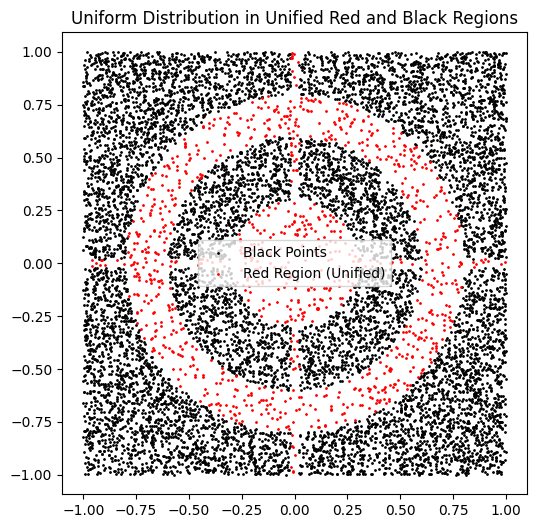

(2, 1000)
(2, 10000)
数据已保存到 target_plot2 文件夹下


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 定义参数
n_red = 1000  # 红色区域点的数量
n_black = 10000  # 黑色区域点的数量
inner_radius = 0.3     # 实心圆的半径
outer_radius_min = 0.6 # 环的内半径
outer_radius_max = 0.8 # 环的外半径

# 定义红色区域判定函数
def is_in_red_region(x, y):
    """
    判断点 (x, y) 是否在红色区域内。
    红色区域包括：
    1. 实心圆：半径 <= inner_radius
    2. 环：外半径 outer_radius_max >= 半径 >= outer_radius_min
    3. 十字线区域：水平线和垂直线
    """
    distance = np.sqrt(x**2 + y**2)
    # 定义十字线区域
    in_horizontal_cross = (-1.0 <= x <= 1.0) and (-0.02 <= y <= 0.02)  # 水平线
    in_vertical_cross = (-0.02 <= x <= 0.02) and (-1.0 <= y <= 1.0)  # 垂直线
    # 判断是否在红色区域
    return (distance <= inner_radius or 
            (outer_radius_min <= distance <= outer_radius_max) or 
            in_horizontal_cross or in_vertical_cross)

# 生成红色区域的均匀分布点
red_x, red_y = [], []
while len(red_x) < n_red:
    x = np.random.uniform(-1, 1)  # 在整个空间中随机生成点
    y = np.random.uniform(-1, 1)
    if is_in_red_region(x, y):  # 筛选属于红色区域的点
        red_x.append(x)
        red_y.append(y)

# 生成黑色区域的均匀分布点
black_x, black_y = [], []
while len(black_x) < n_black:
    x = np.random.uniform(-1, 1)
    y = np.random.uniform(-1, 1)
    if not is_in_red_region(x, y):  # 筛选不属于红色区域的点
        black_x.append(x)
        black_y.append(y)

print(len(red_x))
print(len(black_x))

# 绘图
plt.figure(figsize=(6, 6))
plt.scatter(black_x, black_y, c='black', s=1, label="Black Points")
plt.scatter(red_x, red_y, c='red', s=1, label="Red Region (Unified)")
plt.title("Uniform Distribution in Unified Red and Black Regions")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis("equal")
plt.legend()
plt.show()

# 定义保存路径
save_dir = "./target_plot2"
os.makedirs(save_dir, exist_ok=True)

# 保存红色区域数据
red_data = np.array([red_x, red_y])
print(red_data.shape)
# np.save(os.path.join(save_dir, "red_region.npy"), red_data)

# 保存黑色区域数据
black_data = np.array([black_x, black_y])
print(black_data.shape)
# np.save(os.path.join(save_dir, "black_region.npy"), black_data)

print("数据已保存到 target_plot2 文件夹下")
